### Projet done by :   

1.   **Guedidi Hedi**
2.   **Hammoutène Rafik** 
3.   **Ndiaye Mairame** 

# Introduction
The goal of this exam is to validate your skills with the Spark distributed computing software. You will build and test several more or less simple implementations of recommendation systems.

In the first part of the notebook, you will build a first set of algorithms to infer rules from a dataset. They are known as 'Association Rules':

- "if I observe this, then it is very likely that there is also that."
- "if John is buying potatoes and bread, he's likely to cook burgers tonight. He might be interested in salad and steak too...)

In the second part of the notebook, we will implement the PLSI algorithm ("Probabilistic Latent Semantic Indexing"), which is one way to create embeddings from a dataset. These embeddings can be used to fuel a recommendation engine.

# Setup

## Install Spark Environment
Since we are not running on databricks, we will need to install Spark by ourselves, every time we run the session.  
We need to install Spark, as well as a Java Runtime Environment.  
Then we need to setup a few environment variables.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!curl -O https://dlcdn.apache.org/spark/spark-3.2.3/spark-3.2.3-bin-hadoop3.2.tgz
!tar xf spark-3.2.3-bin-hadoop3.2.tgz
!pip install -q findspark

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  287M  100  287M    0     0   181M      0  0:00:01  0:00:01 --:--:--  181M


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.3-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().set('spark.ui.port', '4050')
sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate()

## Optional step : Enable SparkUI through secure tunnel
This step is useful if you want to look at Spark UI.
First, you need to create a free ngrok account : https://dashboard.ngrok.com/login.  
Then connect on the website and copy your AuthToken.

In [4]:
# this step downloads ngrok, configures your AuthToken, then starts the tunnel
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
!./ngrok authtoken 2IdKT3Yj1aSsHraZF1LWHlikeVP_81hkUdgjcr9YnmNiy6CW # <-------------- change this line !
get_ipython().system_raw('./ngrok http 4050 &')

--2023-02-05 21:11:49--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.161.241.46, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  5.96MB/s    in 2.2s    

2023-02-05 21:11:52 (5.96 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


## Other Imports

In [66]:
import matplotlib.pyplot as plt
import urllib.request as req
import pandas as pd
import numpy as np
import zipfile
import sys
import glob
import math



from pyspark.sql.types import ArrayType, StructType, StructField, StringType
from pyspark.sql.functions import udf,row_number,col,explode,split,hash,lit,array_except
from pyspark.sql.types import ArrayType, IntegerType
from datetime import datetime
from pyspark.sql import (
    functions as F,
    Row
)
from IPython.lib.display import exists
from pyspark.sql.window import Window
from pyspark import StorageLevel



%matplotlib inline


# Part A - Dataset

## Loading the dataset

In [6]:
url = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'
filehandle, _ = req.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
zip_file_object.namelist()
zip_file_object.extractall()

In [7]:
!ls

ml-20m	ngrok-stable-linux-amd64.zip  spark-3.2.3-bin-hadoop3.2
ngrok	sample_data		      spark-3.2.3-bin-hadoop3.2.tgz


In [8]:
movies_path = "ml-20m/movies.csv"
ratings_path = "ml-20m/ratings.csv"

In [9]:
ratings_df = spark.read.options(header=True, inferSchema=True).csv(ratings_path)
movies_df = spark.read.options(header=True, inferSchema=True).csv(movies_path)

#### Toy dataframe 

In [10]:
toy_rating_df=ratings_df.sample(0.05)
toy_movies_df=movies_df.sample(0.05)

## Preprocessing
In the following sections, we will work with algorithms that may scale more or less well with the size of the dataset. In this section we will develop several functions that will allow you to sample the dataset. Then in the next part of the notebook, it will be up to you to choose which tools you want to apply to your dataset in order to train your models, knowing that we want to have reasonable processing times (in the order of a minute), while having models that 'work' well.

**Test all the functions that process the dataframe on a toy example, like what is done in first data processing question.**

### Question
Write the *ratings_df* and *movies_df* and movies datasets in parquet.

Reload them from parquet, to make next computations faster.

In [11]:
#writing ratings in parquet 
ratings_parquet_path = "ml-20m/ratings.parquet"
ratings_df.write.mode("ignore").parquet(ratings_parquet_path)

#writing movies in parquet
movies_parquet_path = "ml-20m/movies.parquet"
movies_df.write.mode("ignore").parquet(movies_parquet_path)

In [12]:
#read rating_parquet_path
ratings_df=spark.read.parquet(ratings_parquet_path)
ratings_df.show(3)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      2|   3.5|1112486027|
|     1|     29|   3.5|1112484676|
|     1|     32|   3.5|1112484819|
+------+-------+------+----------+
only showing top 3 rows



In [13]:
#read movies_parquet_path 
movies_df=spark.read.parquet(movies_parquet_path)
movies_df.show(3)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
+-------+--------------------+--------------------+
only showing top 3 rows



### Question
Compute an estimation of the whole *ratings_df* dataset size in memory. To do this, you can collect 1000 lines of the dataframe, then apply *sys.getsizeof* to it. Then you can extrapolate to the whole dataset.

Find the amount of partitions used by *ratings_df*.

We try to have partitions not too big (in order not to crash our executors), and not to small (dealing with too many small partitions can lead to issues, on driver side for example). For this reason, a rule of thumb to have partitions of 128MB is okay. Given this, what do you think of the dataframe ? Is the amount of partitions okay ? Or should we repartition it ? What would be the function to use if we need to repartition the dataframe ?

In [90]:
rating_parquet=spark.read.parquet(ratings_parquet_path)
size_sample_1000=sys.getsizeof(rating_parquet.take(1000))
size_per_sample=size_sample_1000/1000

global_size = size_per_sample*rating_parquet.count()
print("estimation of the whole ratings_df : ", global_size, " octets")

estimation of the whole ratings_df :  170722244.968  octets


In [91]:
rating_parquet.rdd.getNumPartitions()
print("estimation of the whole ratings_df : ", global_size/1e6, " MB")

estimation of the whole ratings_df :  170.72224496799998  MB


In [92]:
global_size_in_mb=global_size/1e6
print("estimation of the whole ratings_df : ", global_size_in_mb, " MB")

estimation of the whole ratings_df :  170.72224496799998  MB


**We have got 4 partitions and an estimation of the whole dataset of around 170 MB. 2 partitions seem more appropriate for this case. We can use the repartition function.**

In [93]:
number_of_partition_wanted=math.ceil(global_size_in_mb/128)
print("Ideal number of partitions : ", number_of_partition_wanted)

Ideal number of partitions :  2


In [94]:
rating_parquet.repartition(2)

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]

In [95]:
rating_parquet.rdd.getNumPartitions()

2

### Question
Create a function named *remove_bad_ratings* that takes a rating dataframe as an argument, and returns a dataframe whose ratings are greater or equals to a rating_threshold, with default value of *3.5*.

In [96]:
def remove_bad_ratings(rating_dataframe, rating_threshold = 3.5):
  """Filter ratings according to a given threshold 
  Args:
    rating_dataframe: DataFrame
    rating_threshold:flaot 
  Returns:
    DataFrame
  """

  return(rating_dataframe.filter("rating>=%s"%rating_threshold))

df = remove_bad_ratings(ratings_df,3.5)
df.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      2|   3.5|1112486027|
|     1|     29|   3.5|1112484676|
|     1|     32|   3.5|1112484819|
|     1|     47|   3.5|1112484727|
|     1|     50|   3.5|1112484580|
+------+-------+------+----------+
only showing top 5 rows



### Question
Create a function named *sample_users* that takes a rating dataframe as an argument, and returns a dataframe with only a *ratio* of users (we want to keep all ratings from users that we keep) ; default value of *ratio* parameter is *0.1*. Function should be deterministic.

#### Avec le take 

In [97]:
def sample_users(rating_dataframe, ratio = 0.1):
  """Sample of users 
  Args:
    ration: float 
    rating_dataframe: DataFrame
  """

  only_users = rating_dataframe.select("userId").distinct()
  size_new_dataframe = ratio * only_users.count()
  taken_users = spark.createDataFrame(only_users.take(int(size_new_dataframe)))
  new_df = rating_dataframe.join(taken_users,"userId","inner")

  return new_df

df = sample_users(ratings_df)
df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|    26|     10|   3.0|839270709|
|    26|     19|   3.0|839270773|
|    26|     21|   4.0|839270773|
|    26|     22|   3.0|839270953|
|    26|     39|   4.0|839270792|
+------+-------+------+---------+
only showing top 5 rows



#### Sans le take 

In [98]:
def sample_users(rating_dataframe, ratio = 0.1):
  """Sample of users 
  Args:
    ration: float 
    rating_dataframe: DataFrame
  """

  only_users = rating_dataframe.select("userId").distinct()
  only_users=only_users.sample(ratio)
  new_df = rating_dataframe.join(only_users,"userId","inner")
  
  return new_df
df = sample_users(ratings_df)
df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|    12|      1|   4.0|859063718|
|    12|      3|   3.0|859063774|
|    12|      5|   2.0|859063774|
|    12|      6|   3.0|859063774|
|    12|      7|   3.0|859063774|
+------+-------+------+---------+
only showing top 5 rows



### Question
Create a function named *remove_exotic_movies*, taking a rating dataframe as argument, and that removes all movies which have less than *nb_min_ratings* ; *nb_min_ratings* parameter has a default value of *1000*.

In [99]:
def remove_exotic_movies(rating_dataframe, nb_min_ratings = 1000):
  """Remove exotic movies 
  Args:
    rating_dataframe : DataFrame
    nb_min_ratings: int 
  """
  movies_to_keep=rating_dataframe.groupby("movieId").agg({"userId": "count"}).filter("count(userId)>=%s"%nb_min_ratings).select("movieId")
  exotic_removed=rating_dataframe.join(movies_to_keep, "movieId","inner")

  return exotic_removed


exotic_movies_removed_df=remove_exotic_movies(ratings_df)
exotic_movies_removed_df.show(5)

print("Number of rows of exotics movies after being removed is",exotic_movies_removed_df.count())
print("Number of rows of ratings_df is ",ratings_df.count())

+-------+------+------+----------+
|movieId|userId|rating| timestamp|
+-------+------+------+----------+
|   3997|     1|   3.5|1112486192|
|   1580|     2|   4.0| 974820748|
|   3918|     2|   3.0| 974820943|
|   2366|     3|   4.0| 944918310|
|   1580|     7|   3.0|1011206832|
+-------+------+------+----------+
only showing top 5 rows

Number of rows of exotics movies after being removed is 17765516
Number of rows of ratings_df is  20000263


### Question
Compute the following stats on the dataset:
- Amount of distinct users
- Amount of distinct movies
- Total amount of ratings
- Let r_u be the amount of ratings made by user u. Study the distribution of r_u over all users (quantiles, histogram...)

Amount of distinct users :  138493
Amount of distinct movies :  27278
Total amount of ratings :  20000263


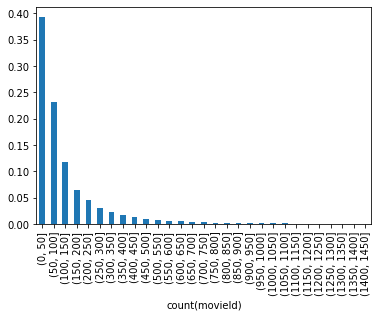

In [100]:
#Amount of distinct users 
number_of_distinct_users=ratings_df.select("userId").distinct().count()
print("Amount of distinct users : ",number_of_distinct_users)


#Amount of distinct movies 
number_of_distinct_movies=movies_df.select("movieId").distinct().count()
print("Amount of distinct movies : ",number_of_distinct_movies)


#Total amount of ratings
number_of_ratings=ratings_df.count()
print("Total amount of ratings : ",number_of_ratings)



#We assume that a user can only rate a movie once
count_per_user=ratings_df.groupby("userId").agg({"movieId": "count"})
count_per_number_of_reviews=count_per_user.groupby("count(movieId)").agg({"userId": "count"})
count_per_number_of_reviews = count_per_number_of_reviews.sort('count(movieId)')
count_per_number_of_reviews_pd=pd.DataFrame(count_per_number_of_reviews.collect(),columns=['count(movieId)', 'count(userId)']).reset_index(drop=True)
count_per_number_of_reviews_pd["freq"]=count_per_number_of_reviews_pd["count(userId)"] / count_per_number_of_reviews_pd["count(userId)"].sum()
bins = range(0,1500,50)
df = count_per_number_of_reviews_pd.groupby(pd.cut(count_per_number_of_reviews_pd['count(movieId)'], bins=bins)).sum("freq")
df["freq"].plot(kind='bar')

In [101]:
#QUANTILES
count_per_user_sorted=count_per_user.sort('count(movieId)')
print("25% .........")
count_per_user_sorted.summary("25%").show()
print("50% .........")
count_per_user_sorted.summary("50%").show()
print("75% .........")
count_per_user_sorted.summary("75%").show()

25% .........
+-------+------+--------------+
|summary|userId|count(movieId)|
+-------+------+--------------+
|    25%| 34621|            35|
+-------+------+--------------+

50% .........
+-------+------+--------------+
|summary|userId|count(movieId)|
+-------+------+--------------+
|    50%| 69239|            68|
+-------+------+--------------+

75% .........
+-------+------+--------------+
|summary|userId|count(movieId)|
+-------+------+--------------+
|    75%|103861|           155|
+-------+------+--------------+



### Question
Create a function named *remove_old_movies_in_timelines*, that takes a ratings dataframe as parameter, and only keeps the *nb_max_movies* most recent movies seen by each user ; *nb_max_movies* parameter is defaulted at 100.

In [102]:
def remove_old_movies_in_timelines(movies_df,ratings_df,nb_max_movies=100):
  """Remove old movies in timelines 
  Args:
    movies_df: Dataframe 
    ratings_df: DataFrame
    nb_max_movies: int 
  """
  years_df = movies_df.withColumn("annee",F.regexp_extract("title", '\((\d+)\)',1))
  ratings_df=ratings_df.select("userId","movieId")
  years_df=years_df.select("movieId","annee")
  users_year=ratings_df.join(years_df,"movieId","inner")
  window_spec=Window.partitionBy("userId").orderBy(col("annee").desc())
  df=users_year.withColumn("rank_movies",row_number().over(window_spec))
  dff=df.filter(df['rank_movies']<=nb_max_movies)

  return dff

remove_old_movies_in_timelines(movies_df,ratings_df,nb_max_movies=5).show(truncate=False)

+-------+------+-----+-----------+
|movieId|userId|annee|rank_movies|
+-------+------+-----+-----------+
|31696  |1     |2005 |1          |
|7438   |1     |2004 |2          |
|7449   |1     |2004 |3          |
|7454   |1     |2004 |4          |
|8368   |1     |2004 |5          |
|2448   |3     |1999 |1          |
|2505   |3     |1999 |2          |
|2541   |3     |1999 |3          |
|2567   |3     |1999 |4          |
|2571   |3     |1999 |5          |
|104    |5     |1996 |1          |
|140    |5     |1996 |2          |
|141    |5     |1996 |3          |
|608    |5     |1996 |4          |
|631    |5     |1996 |5          |
|135    |6     |1996 |1          |
|140    |6     |1996 |2          |
|141    |6     |1996 |3          |
|494    |6     |1996 |4          |
|628    |6     |1996 |5          |
+-------+------+-----+-----------+
only showing top 20 rows



# Part B - Association Rules

## Recurring pairs
This approach is simple and not efficient but gives you a baseline and intuition for the next steps.

Morally, what we want to do is:

- for each user, regroup all the movies they have liked inside a single row. We will call this the 'user timeline'
- for each user, generate all pairs of movies across their list of movies.
- for each pair of movies, count the amount of distinct users with this pair.



### Question
Create a function named *compute_timeline*, that takes a ratings dataframe as parameter, and returns the 'user timeline', a dataframe following this schema:
- userId : integer
- movies : list[integer] (list of movieId seen by user)

Test it on a toy example.

In [103]:
def compute_timeline(ratings_df):
  """Compute timeline function 
  Args:
    ratings_df: DataFrames
    Creates a user timeline
  """
  user_timeline = ratings_df.groupBy("userId").agg(F.collect_list("movieId").alias("movies"))

  return user_timeline

### Test on the toy example 

In [104]:
user_timeline=compute_timeline(toy_rating_df)
user_timeline.show(4)

+------+--------------------+
|userId|              movies|
+------+--------------------+
|     1|[47, 924, 1090, 1...|
|     3|[589, 1094, 1215,...|
|     5|[316, 368, 480, 5...|
|     9|        [4369, 4502]|
+------+--------------------+
only showing top 4 rows



#### on the original data 

In [105]:
ct=compute_timeline(ratings_df)
ct.show(4)

+------+--------------------+
|userId|              movies|
+------+--------------------+
|     1|[2, 29, 32, 47, 5...|
|     3|[1, 24, 32, 50, 1...|
|     5|[2, 11, 17, 60, 6...|
|     6|[1, 3, 7, 17, 52,...|
+------+--------------------+
only showing top 4 rows



### Question
Let's imagine that all of our executors have 4GB of memory. If we consider that dataset where movie ratings are greater or equal than 3.5, is it okay to store list of movie ids inside rows, as far as memory is concerned ?

In [73]:
more_equal_three_pointhalf= remove_bad_ratings(ratings_df,3.5)
more_equal_three_pointhalf.count()

12195566

**The answer would be no, because, the executor needs to 
acces the whole values, which surpass the memory of the executor
The memory needed to store its rows of the new dataframe is big, so the execution isn't optimized**


### Question
Create a function named *compute_pairs*, that takes a user timeline dataframe as parameter, and returns a dataframe of movie pairs (generated across all movies of their timeline) following this schema:
- userId : integer
- movieId1 : integer
- movieId2 : integer

You can rely on an udf to generate list of pair of movies from a list of movies.

Test it on a toy example.

In [106]:
def all_pairs(l):
    res=[[i,j] for i in l for j in l if i<j]
    return res

generate_all_pairs = udf(lambda x: all_pairs(x), ArrayType(ArrayType(IntegerType())))

def compute_pairs(user_timeline_df):
    df = user_timeline_df.withColumn("all_pairs_movieId", generate_all_pairs(user_timeline_df["movies"])).select("userId","all_pairs_movieId")
    df=df.select("userId",explode(df.all_pairs_movieId))
    df=df.select("userId",df.col[0].alias("movieid1"),df.col[1].alias("movieid2"))
    return df

In [107]:
computed_pairs=compute_pairs(user_timeline)
computed_pairs.show(20)

+------+--------+--------+
|userId|movieid1|movieid2|
+------+--------+--------+
|     1|      47|     924|
|     1|      47|    1090|
|     1|      47|    1097|
|     1|      47|    1222|
|     1|      47|    1358|
|     1|      47|    2194|
|     1|      47|    2959|
|     1|      47|    2968|
|     1|      47|    3479|
|     1|      47|    4941|
|     1|      47|    5679|
|     1|     924|    1090|
|     1|     924|    1097|
|     1|     924|    1222|
|     1|     924|    1358|
|     1|     924|    2194|
|     1|     924|    2959|
|     1|     924|    2968|
|     1|     924|    3479|
|     1|     924|    4941|
+------+--------+--------+
only showing top 20 rows



### Question
Let's imagine that all of our executors have 4GB of memory. 

If we consider that dataset where movie ratings are greater or equal than 3.5, what will happen when we generate pairs dataframe for this dataset ?

You need to consider:
- amount of bytes retained by lists of pairs
- amount of partitions we have in user timeline

Also, consider what may happen because of skew. We may have all big user timelines inside same partition.

**we consider that dataset where movie ratings are greater or equal than 3.5, what will happen when we generate pairs dataframe for this ?**

**If we generate all possible pairs from a list of size $n$, we will have $n^2$ pairs, therefore the storage space needed to store this pairs, is the storage needed to store all the pairs will be proportional to the size of the initial list to the power of 2, in our case, $(3.5)^2=12.25$ which is way bigger than the 4GB capacity of all our executors.**

**Regarding Skewness, the executors that already have a larger data stored will be much more impacted when $n^2$ is applied (with the n being the number of the data locally stored by the executor)**

**If you had 3.5 GB for the entire dataset, and we wanted a partition of size 170 MB, we would have 21 partitions; If we generate all pairs, we would have 12.25 GB, if you want to keep the partition size of 170, we will need 72 partitions. The number of partitions has largely increased by around 3.5 times**

#### If we try with the "more_equal_three_pointhalf_pair" which is a dataframe having ratings which are greater or equal than 3.5, will will have this following error 

In [ ]:
more_equal_three_pointhalf_pair=compute_pairs(more_equal_three_pointhalf)
more_equal_three_pointhalf_pair.show(3)

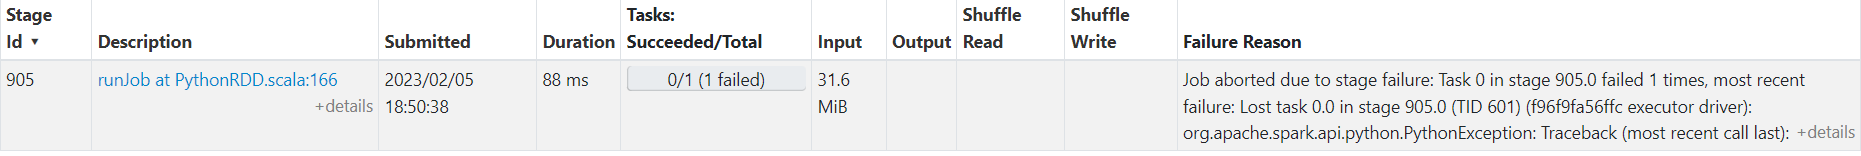

### Question
Create a function named *compute_pair_frequencies*, that takes a movie pair dataframe as parameter, and returns a dataframe of movie pairs and their user count, following this schema:
- movieId1 : integer
- movieId2 : integer
- count : integer

Dataframe should be **ordered**, with most frequent pairs first.

Test it on a toy example.

In [108]:
def compute_pair_frequencies(movie_pairs_df):
  df=movie_pairs_df.groupBy("movieid1","movieid2").count()
  return df 

In [109]:
cpf=compute_pair_frequencies(computed_pairs)
cpf.show(2)

+--------+--------+-----+
|movieid1|movieid2|count|
+--------+--------+-----+
|    4299|    4896|   11|
|     292|    1347|    7|
+--------+--------+-----+
only showing top 2 rows



### Question
Quickly test the whole algorithm on *ratings_df* or a subset of it.

How many shuffles for the whole algorithm ?

###### It takes a lot of time executing. Uncomment if you want to. 

In [ ]:
## aplying cpf for the rating_df
# pairfreq_df=compute_pairs(ct)
# pair_freq_all=compute_pair_frequencies(pairfreq_df)
# pair_freq_all.show(3)

In our code here are the following used shuffles :     
  1. .groupBy() in compute_pair_frequencies 
  2. .groupBy() in compute_timeline

Therefore, the number of shuffle used is **2**

## A priori  
You can find a good description of A priori here :

https://towardsdatascience.com/apriori-association-rule-mining-explanation-and-python-implementation-290b42afdfc6

### Question
Implement your own version of A priori to compute most frequent pairs and quickly test it on *ratings_df* or a subset of it.

You may want to rely on *F.explode* as an alternative to udf.

In [111]:
def scan(rdd):
    #generate all pairs after pruning !! (number of pairs generate is less than the whole number of pairs because the pairs where prune before)
    res_rdd=rdd.flatMap(lambda x : [(i,1) for i in x[1]]).reduceByKey(lambda x,y:x+y)
    return res_rdd

def filter_with_limit(rdd,minSup):
    discarded_items=rdd.filter(lambda x: x[1]<minSup).map(lambda x : x[0])
    kept_items=rdd.filter(lambda x: x[1]>=minSup)
    return discarded_items,kept_items

def local_union(list_movies,number_to_keep):    
    res=[]
    for i in range(len(list_movies)):
        for j in range(i+1,len(list_movies)):
            if(type(list_movies[i])==int):
                set_i=set([list_movies[i]])
                set_j=set([list_movies[j]])
            else:
                set_i=set(list_movies[i])
                set_j=set(list_movies[j])
            union=set_i.union(set_j)
            to_add_candidat=tuple(sorted(union))
            if(len(to_add_candidat)==number_to_keep):
                res.append(to_add_candidat)
    return sorted(list(set(res)))

def getUnion(ratings_rdd,number_of_items_in_itemset):
    rdd_rating_res=ratings_rdd.map(lambda x : (x[0],local_union(x[1],number_of_items_in_itemset)))
    rdd_rating_res=rdd_rating_res.filter(lambda x : len(x[1])>0)
    return rdd_rating_res

def prune_unfrequent_items(ratings_rdd,discarded_item_list):
    res_rdd=ratings_rdd.map(lambda x : (x[0], [i for i in x[1] if i not in discarded_item_list]))
    res_rdd=res_rdd.filter(lambda x : len(x[1])>0)
    return res_rdd

def apriori(ratings_df,minSup,stop_at_length=2):
    ratings_rdd_to_modify=ratings_df.rdd
    #C1
    c=scan(ratings_rdd_to_modify)
    l_discraded_items,l=filter_with_limit(c,minSup)
    for k in range(2,stop_at_length+1) :
        l_discraded_items_list=l_discraded_items.collect()
        ratings_rdd_to_modify=prune_unfrequent_items(ratings_rdd_to_modify,l_discraded_items_list)      
        #We didn't find a way to avoid the collect bellow as storing the frequent items  in an RDD or DataFrame will lead to a lot of costly joins (thus shuffle and sort) down the line. We suppose that the discarded item list is small enough compared to the whole list so it can be store locally in a list.
        ratings_rdd_to_modify=getUnion(ratings_rdd_to_modify,k)
        #Next C
        c=scan(ratings_rdd_to_modify)
        l_discraded_items,l=filter_with_limit(c,minSup)
    frequent_nuplets_df=spark.createDataFrame(l,["Itemset","sup"])
    return frequent_nuplets_df

In [112]:
simple_data = [("1",[1,4,6,9]), ("2",[4,6,9]), ("3",[1,6]),("4",[1,9])]
simple_data_df = spark.createDataFrame(data=simple_data, schema = ["userId","movieId"])

In [ ]:
apriori(simple_data_df,minSup=2,stop_at_length=2).show(4)

In [74]:
apriori(user_timeline,minSup=2,stop_at_length=2).show(4)

+-------------+---+
|      Itemset|sup|
+-------------+---+
|{1597, 79695}|  2|
| {4034, 5378}| 15|
| {2447, 3841}|  2|
|{1136, 54732}|  2|
+-------------+---+
only showing top 4 rows



### Question
Implement your own version of A priori to compute most frequent triplets.

A this stage of the 'A priori' section, you are probably doing the same thing multiple times. 

Maybe it's time to factorize your code...

In [75]:
apriori(simple_data_df,minSup=2,stop_at_length=3).show(4)

+---------+---+
|  Itemset|sup|
+---------+---+
|{4, 6, 9}|  2|
+---------+---+



In [ ]:
#takes considerate time :
#apriori(ct_df_from_parquet,minSup=3,stop_at_length=3).show(4)

**The written code doesn't seem to be optimized, it works well on small data, but struggles with larger data because it takes quite a lot of time, maybe if we've used dataframes instead of RDD, would have made the code execution faster**

**The code works well for pairs and struggles for finding triplets**

## 3. FP-Growth

### Question
Use the Spark version of fpgrowth:

https://spark.apache.org/docs/2.3.0/ml-frequent-pattern-mining.html

In [77]:
from pyspark.ml.fpm import FPGrowth
fpGrowth = FPGrowth(itemsCol="movies", minSupport=0.0001, minConfidence=0.1)
model = fpGrowth.fit(user_timeline)
# Display frequent itemsets.
model.freqItemsets.show(4)
model.associationRules.show(4)

/content/spark-3.2.3-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+-------+----+
|  items|freq|
+-------+----+
| [3653]|  38|
|[78105]|  55|
| [3446]|  16|
| [3197]|  54|
+-------+----+
only showing top 4 rows

+----------+----------+-------------------+------------------+--------------------+
|antecedent|consequent|         confidence|              lift|             support|
+----------+----------+-------------------+------------------+--------------------+
|    [1010]|     [586]|0.10869565217391304| 9.322263714768383|1.192207730274923E-4|
|    [1542]|    [1196]|0.11016949152542373| 5.933730700023218|  1.0332466995716E-4|
|    [7256]|    [2858]| 0.1320754716981132| 7.215518724551241|1.112727214923261...|
|    [4994]|    [3114]|             0.1625|18.320127688172047|  1.0332466995716E-4|
+----------+----------+-------------------+------------------+--------------------+
only showing top 4 rows



# Part C - Probabilistic Latent Semantic Model
Aim of this section is to implement a Probabilistic Latent Semantic Model.

We will use an expectation maximization algorithm to learn its parameters.

In the first set of questions you will implement some utility functions to deal with matrix manipulations.

In the second set of questions, you will implement the algorithm itself.

## Matrix manipulation functions
We will implement matrix operations that will be usefull to run the PLSI algorithm afterwards.

#### `matrix_sum_rows` 
Takes a matrix (a column containing arrays of fixed length) and returns the sum of each row.

In [22]:
# Hint: https://stackoverflow.com/a/57448698/2015762
def matrix_sum_rows(col_name, length_of_array):
  sum_rows =  sum([F.col(col_name).getItem(i) for i in range(length_of_array)])
  
  return sum_rows

input_array = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
expected_output = input_array.sum(axis=1)
print('Input array')
print(input_array)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    spark.sparkContext.parallelize(input_array.tolist()).map(lambda x: Row(matrix=x)).toDF()
    .withColumn('row_sum', matrix_sum_rows('matrix', 4))
).show(truncate=False)

Input array
[[ 1.  2.  3.  4.]
 [40. 30. 20. 10.]]
Expected output
[ 10. 100.]
Obtained output
+------------------------+-------+
|matrix                  |row_sum|
+------------------------+-------+
|[1.0, 2.0, 3.0, 4.0]    |10.0   |
|[40.0, 30.0, 20.0, 10.0]|100.0  |
+------------------------+-------+



#### `matrix_sum_columns`
Takes a matrix (a column containing arrays of fixed length) and returns the sum of each column.

In [23]:
# Hint: https://stackoverflow.com/a/54382990/2015762
def matrix_sum_columns(col_name, length_of_array):
    bla = F.array(*[F.sum(F.col(col_name)[i]) for i in range(length_of_array)])

    return bla

input_array = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
expected_output = input_array.sum(axis=0)
print('Input array')
print(input_array)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    spark.sparkContext.parallelize(input_array.tolist()).map(lambda x: Row(matrix=x)).toDF()
    .select(matrix_sum_columns('matrix', 4).alias('col_sum'))
).show(truncate=False)

Input array
[[ 1.  2.  3.  4.]
 [40. 30. 20. 10.]]
Expected output
[41. 32. 23. 14.]
Obtained output
+------------------------+
|col_sum                 |
+------------------------+
|[41.0, 32.0, 23.0, 14.0]|
+------------------------+



#### `matrix_normalize_rows`
Takes a matrix (a column containing arrays of fixed length) and returns the same matrix where the rows have been divded by their sum, such that each row sums to 1.

In [24]:
def matrix_normalize_rows(col_name, length_of_array):
  normalized=F.array([F.col(col_name).getItem(i)/sum([F.col(col_name).getItem(j) 
                                                    for j in range(length_of_array)]) 
            for i in range(length_of_array)])

  return normalized

input_array = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
expected_output = input_array / input_array.sum(axis=1).reshape(-1, 1)
print('Input array')
print(input_array)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    spark.sparkContext.parallelize(input_array.tolist()).map(lambda x: Row(numbers=x)).toDF()
    .withColumn('normalized_elements', matrix_normalize_rows('numbers', 4))
).show(truncate=False)

Input array
[[ 1.  2.  3.  4.]
 [40. 30. 20. 10.]]
Expected output
[[0.1 0.2 0.3 0.4]
 [0.4 0.3 0.2 0.1]]
Obtained output
+------------------------+--------------------+
|numbers                 |normalized_elements |
+------------------------+--------------------+
|[1.0, 2.0, 3.0, 4.0]    |[0.1, 0.2, 0.3, 0.4]|
|[40.0, 30.0, 20.0, 10.0]|[0.4, 0.3, 0.2, 0.1]|
+------------------------+--------------------+



#### `matrix_elementwise_product`
Takes two matrices and return their elementwise product (aka. Hadamard product)

In [25]:
def matrix_elementwise_product(col_name_1, col_name_2, length_of_array):
    res=F.array(*[F.col(col_name_1).getItem(i)*F.col(col_name_2).getItem(i) for i in range(length_of_array)])
    return res

input_array_1 = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
input_array_2 = np.array([[1, 2, 1, 2], [10, 20, 10, 20]], dtype=float)
expected_output = input_array_1 * input_array_2
print('Input array')
print(input_array_1)
print(input_array_2)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    spark.sparkContext.parallelize(zip(input_array.tolist(), input_array_2.tolist())).map(lambda x: Row(numbers_1=x[0], numbers_2=x[1])).toDF()
    .withColumn('elementwise_products', matrix_elementwise_product('numbers_1', 'numbers_2', 4))
).show(truncate=False)

Input array
[[ 1.  2.  3.  4.]
 [40. 30. 20. 10.]]
[[ 1.  2.  1.  2.]
 [10. 20. 10. 20.]]
Expected output
[[  1.   4.   3.   8.]
 [400. 600. 200. 200.]]
Obtained output
+------------------------+------------------------+----------------------------+
|numbers_1               |numbers_2               |elementwise_products        |
+------------------------+------------------------+----------------------------+
|[1.0, 2.0, 3.0, 4.0]    |[1.0, 2.0, 1.0, 2.0]    |[1.0, 4.0, 3.0, 8.0]        |
|[40.0, 30.0, 20.0, 10.0]|[10.0, 20.0, 10.0, 20.0]|[400.0, 600.0, 200.0, 200.0]|
+------------------------+------------------------+----------------------------+



#### `matrix_elementwise_divide`
Takes two matrices and divide elementwise the first one by the second one.

In [26]:
def matrix_elementwise_divide(col_name_1, col_name_2, length_of_array):
  res=F.array(*[F.col(col_name_1).getItem(i)/F.col(col_name_2).getItem(i) for i in range(length_of_array)])
  return res


input_array_1 = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
input_array_2 = np.array([[1, 2, 1, 2], [10, 20, 10, 20]], dtype=float)
expected_output = input_array_1 / input_array_2
print('Input array')
print(input_array_1)
print(input_array_2)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    spark.sparkContext.parallelize(zip(input_array.tolist(), input_array_2.tolist())).map(lambda x: Row(numbers_1=x[0], numbers_2=x[1])).toDF()
    .withColumn('elementwise_divided', matrix_elementwise_divide('numbers_1', 'numbers_2', 4))
).show(truncate=False)

Input array
[[ 1.  2.  3.  4.]
 [40. 30. 20. 10.]]
[[ 1.  2.  1.  2.]
 [10. 20. 10. 20.]]
Expected output
[[1.  1.  3.  2. ]
 [4.  1.5 2.  0.5]]
Obtained output
+------------------------+------------------------+--------------------+
|numbers_1               |numbers_2               |elementwise_divided |
+------------------------+------------------------+--------------------+
|[1.0, 2.0, 3.0, 4.0]    |[1.0, 2.0, 1.0, 2.0]    |[1.0, 1.0, 3.0, 2.0]|
|[40.0, 30.0, 20.0, 10.0]|[10.0, 20.0, 10.0, 20.0]|[4.0, 1.5, 2.0, 0.5]|
+------------------------+------------------------+--------------------+



## PLSI
With
* N the number of users u
* M the number of movies s
* L the number of latent classes z
* T number of user, movie interactions (each interaction (s_t, u_t) means user u_t liked movie s_t)

We suppose that the probability that a user will like a movie can be written in the form of a mixture model given by the equation:
$$
p(s|u) = \sum_{z=1}^L p(s|z) p(z|u)
$$
And we want to optimize the likelihood of the observed user interactions
$$
L = - \frac{1}{T} \sum_{1}^{T} \log p(s_t|u_t) = - \frac{1}{T} \sum_{1}^{T} \sum_{z=1}^L p(s_t|z) p(z|u_t)
$$
That can be done using an EM algorithm working as follow:

**E step**

For each interaction (u_t, s_t), compute for all z = 1, ..., L:
$$
p(z|(u_t, s_t)) = \frac{p(s_t|z) p(z|u_t)}{\sum_z p(s_t|z) p(z|u_t)}
$$

**M step**

Find each movie probability given a latent class
$$
p(s|z) = \frac{N(z, s)}{N(z)} 
\quad \text{where} \quad N(z, s) = \sum_s \sum_u p(z|(u, s)) 
\quad \text{and} \quad N(z) = \sum_s N(z, s)
$$
Find each latent class probability given each user.
$$
p(z|u) = \frac{\sum_s p(z|(u, s))}{\sum_z \sum_s p(z|(u, s))}
$$

We will have the following dataframes

* `count_z_s`: M rows, with columns  `movieId`, `N(z,s)`.
* `count_z`: 1 row, with column `N(z)`.
* `p_s_knowing_z`: M rows, with columns  `movieId`, `p(s|z)`. For a given z, the sum of p(s|z) equals 1.
* `p_z_knowing_u`: N rows, with columns `userId`, `p(z|u)`. For a given u, the sum of p(z|u) equals 1.
* `p_z_knowing_u_and_s`: N x M rows, with columns `userId`, `movieId`, `p(z|u,s)`.

### Question
Implement the PLSI algorithm

In [27]:
#There's M=2 rows here with columns MovieId
count_z_s = spark.sparkContext.parallelize([
    Row(**{"movieId":1, "N(z,s)": [1., 3., 4.]}),
    Row(**{"movieId":2, "N(z,s)": [4., 5., 0.]}),
]).toDF()

count_z_s.show()

+-------+---------------+
|movieId|         N(z,s)|
+-------+---------------+
|      1|[1.0, 3.0, 4.0]|
|      2|[4.0, 5.0, 0.0]|
+-------+---------------+



In [28]:
#For testing only 
p_z_knowing_u_and_s = spark.sparkContext.parallelize([
    Row(**{"userId":1, "movieId":1, "p(z|u,s)": [0.3, 0.5, 0.2]}),
    Row(**{"userId":2, "movieId":1, "p(z|u,s)": [0.1, 0.6, 0.3]}),
    Row(**{"userId":1, "movieId":2, "p(z|u,s)": [0.2, 0.7, 0.1]}),
    Row(**{"userId":2, "movieId":2, "p(z|u,s)": [0.4, 0.4, 0.2]}),
]).toDF()

p_z_knowing_u_and_s.show()

+------+-------+---------------+
|userId|movieId|       p(z|u,s)|
+------+-------+---------------+
|     1|      1|[0.3, 0.5, 0.2]|
|     2|      1|[0.1, 0.6, 0.3]|
|     1|      2|[0.2, 0.7, 0.1]|
|     2|      2|[0.4, 0.4, 0.2]|
+------+-------+---------------+



**count_z: 1 row, with column N(z).**

In [29]:
def get_count_z(count_z_s, n_latent_classes):
    """Compute N(z) = sum_s N(z,s)
    """
    res=count_z_s.agg(matrix_sum_columns(count_z_s.columns[1],n_latent_classes).alias("N(z)"))
    
    return res

count_z_s = spark.sparkContext.parallelize([
    Row(**{"movieId":1, "N(z,s)": [1., 3., 4.]}),
    Row(**{"movieId":2, "N(z,s)": [4., 5., 0.]}),
]).toDF()
get_count_z(count_z_s, 3).show()
# Expected [5., 8., 4.]

+---------------+
|           N(z)|
+---------------+
|[5.0, 8.0, 4.0]|
+---------------+



***`count_z_s`: M rows, with columns  `movieId`, `N(z,s)`.***

In [30]:
def get_count_z_s(p_z_knowing_u_and_s, n_latent_classes):
  """
  Compute N(z,s) = sum_u p(z|u,s)
  p_z_knowing_u_and_s: N x M rows, with columns userId, movieId, p(z|u,s).
  """
  res=p_z_knowing_u_and_s.groupBy(p_z_knowing_u_and_s.columns[1]).agg(
          matrix_sum_columns(p_z_knowing_u_and_s.columns[2],n_latent_classes).alias("N(z,s)")
    )
  return res 

get_count_z_s(p_z_knowing_u_and_s,3).show()

+-------+--------------------+
|movieId|              N(z,s)|
+-------+--------------------+
|      1|     [0.4, 1.1, 0.5]|
|      2|[0.60000000000000...|
+-------+--------------------+



* `p_s_knowing_z`: M rows, with columns  `movieId`, `p(s|z)`. For a given z, the sum of p(s|z) equals 1.

In [31]:
def get_p_s_knowing_z(count_z_s, count_z, n_latent_classes):
    """Compute p(s|z) = N(z,s) / N(z)
    Hint: crossJoin may help
    """
    cross_joined_df=count_z_s.crossJoin(count_z)

    res=cross_joined_df.select(cross_joined_df.columns[0],matrix_elementwise_divide(cross_joined_df.columns[1],cross_joined_df.columns[2],n_latent_classes).alias("P(s|z)"))

    return res

get_p_s_knowing_z(count_z_s,get_count_z(count_z_s,3),3).show()

+-------+-----------------+
|movieId|           P(s|z)|
+-------+-----------------+
|      1|[0.2, 0.375, 1.0]|
|      2|[0.8, 0.625, 0.0]|
+-------+-----------------+



* `p_z_knowing_u`: N rows, with columns `userId`, `p(z|u)`. For a given u, the sum of p(z|u) equals 1.

$$
p(z|u) = \frac{\sum_s p(z|(u, s))}{\sum_z \sum_s p(z|(u, s))}
$$

In [32]:
def get_p_z_knowing_u(p_z_knowing_u_and_s,n_latent_classes):
  numerateur = p_z_knowing_u_and_s.groupBy("userId").agg(matrix_sum_columns(p_z_knowing_u_and_s.columns[2],n_latent_classes).alias("Numerateur"))
  normalisation = numerateur.select("userId",matrix_normalize_rows(numerateur.columns[1],n_latent_classes).alias('p(z|u)'))
  return normalisation
  
get_p_z_knowing_u(p_z_knowing_u_and_s, 3).show()

+------+--------------------+
|userId|              p(z|u)|
+------+--------------------+
|     1|[0.25, 0.6, 0.150...|
|     2|   [0.25, 0.5, 0.25]|
+------+--------------------+



$$
p(z|(u_t, s_t)) = \frac{p(s_t|z) p(z|u_t)}{\sum_z p(s_t|z) p(z|u_t)}
$$

In [33]:
from pyspark.sql.types import IntegerType,DoubleType
def get_p_z_knowing_u_and_s(observed_pairs, count_z_s, count_z, p_z_knowing_u, n_latent_classes):
    """For all pairs of observed (u, s)    Compute p(z|u,s) = [N(z, s) / N(z) * p(z|u)] / sum_z [N(z, s) / N(z) * p(z|u)] = [p(s|z) * p(z|u)] / sum_z [p(s|z) * p(z|u)]    """    
    p_s_knowing_z = get_p_s_knowing_z(count_z_s, count_z, n_latent_classes)
    schema = StructType([
    StructField("userId", IntegerType(), True),
    StructField("movieId", IntegerType(), True),
    StructField("p(z|u,s)", ArrayType(DoubleType()), True)])
    result_df = spark.createDataFrame(data=[], schema=schema)
    observed_pairs_recup =  observed_pairs.collect()
    for elem in observed_pairs_recup:
      u=elem[0]
      s=elem[1]
      value_p_s_knowing_z = p_s_knowing_z.filter(p_s_knowing_z.movieId == s).select('P(s|z)').first()[0]
      value_p_z_knowing_u = p_z_knowing_u.filter(p_z_knowing_u.userId == u).select('p(z|u)').first()[0]
      df1 = spark.createDataFrame([(u,s,value_p_s_knowing_z,value_p_z_knowing_u)], ["userId", "movieId","P(s|z)","p(z|u)"])
      numerateur =df1.withColumn("numerateur",matrix_elementwise_product(df1.columns[2],df1.columns[3], n_latent_classes))
      num_sur_denom = numerateur.select("userId","movieId",matrix_normalize_rows(numerateur.columns[4],n_latent_classes).alias('p(z|u,s)'))
      result_df = result_df.union(num_sur_denom)
    return result_df

**T number of user, movie interactions (each interaction (s_t, u_t) means user u_t liked movie s_t)**
$$
L = - \frac{1}{T} \sum_{1}^{T} \log p(s_t|u_t) = - \frac{1}{T} \sum_{1}^{T} \sum_{z=1}^L p(s_t|z) p(z|u_t)
$$

In [34]:
def log_likelihood(observed_pairs,p_z_knowing_u,p_s_knowing_z,n_latent_classes):
  """Compute the log likelihood of the observed pairs
  """ 
  from pyspark.sql.functions import mean 

  o=observed_pairs.join(p_z_knowing_u,on='userId',how="inner")\
                    .join(p_s_knowing_z,on='movieId',how="inner")

                    
  #p(s|z) * p(z|u) 
  o=o.withColumn("term",matrix_elementwise_product(
                                o.columns[3],
                                o.columns[2],
                                n_latent_classes))
   
  #somme de 1 à n_latent_classe de p(s_t,z)p(z,u_t) (somme sur les lignes) 
  o=o.withColumn("somme_z",matrix_sum_rows(o.columns[4],n_latent_classes))
  res=o.select(mean("somme_z"))
  res=(res.first()[0])*(-1)
  return res

### Initialisation random 

In [35]:
def initialize_statistics(observed_pairs, n_latent_classes):
    """Initialize either p(s|z) and p(z|u) or p(z|(u, s)) to be able to fuel the first iteration of the EM algorithm.
    What would happen if you initialize these to a constant value ?
    """
    import random
    from pyspark.sql.types import ArrayType, FloatType

    def generate_random():
      random_list=[random.random() for i in range(n_latent_classes)]
      sum_of_random=sum(random_list)

      return [float(i)/sum_of_random for i in random_list]

    udf_generate_random=F.udf(generate_random,ArrayType(FloatType()))
    res=observed_pairs.withColumn("p(z|u,s",udf_generate_random())
    return res

### So we've tried using a uniform initialization, but we observed that the LLH got the same value no matter how the number of iterations was taken

### Initialisation uniforme

In [36]:
def run_plsi(observed_pairs, n_iterations, n_latent_classes, checkpoint_every=1):
    start_init_time = time.time()
    spark.sparkContext.setJobDescription("Initialization")
    p_z_knowing_u_and_s= initialize_statistics(observed_pairs, n_latent_classes)
    count_z_s=get_count_z_s(p_z_knowing_u_and_s, n_latent_classes)
    count_z=get_count_z(count_z_s, n_latent_classes)
    p_s_knowing_z=get_p_s_knowing_z(count_z_s, count_z, n_latent_classes)
    p_z_knowing_u=get_p_z_knowing_u(p_z_knowing_u_and_s,n_latent_classes)
    llh = log_likelihood(observed_pairs,p_z_knowing_u,p_s_knowing_z,n_latent_classes)
    mlflow.log_metric(key="llh", value=llh, step=0)
    print(f'LLH: {llh:.10f}')
    end_init_time = time.time()
    print(f'Initialization: {end_init_time - start_init_time:.1f}s')
    for i in range(n_iterations):
        start_e_step = time.time()
        spark.sparkContext.setJobDescription(f"Iteration {i+1}: E-step")
        # E step
        p_z_knowing_u_and_s=get_p_z_knowing_u_and_s(observed_pairs, count_z_s, count_z, p_z_knowing_u, n_latent_classes)
        end_e_step = time.time()
        print(f'Iteration {i+1}: E-step: {end_e_step - start_e_step:.1f}s')
        spark.sparkContext.setJobDescription(f"Iteration {i+1}: M-step")
        # M step
        # ...
        count_z_s=get_count_z_s(p_z_knowing_u_and_s, n_latent_classes)
        count_z=get_count_z(count_z_s, n_latent_classes)
        p_s_knowing_z=get_p_s_knowing_z(count_z_s,count_z,n_latent_classes)
        count_z_s.unpersist() #unpersist here
        count_z.unpersist() #unpersist here
        p_z_knowing_u=get_p_z_knowing_u(p_z_knowing_u_and_s,n_latent_classes)
        p_z_knowing_u_and_s.unpersist()
        llh = log_likelihood(observed_pairs,p_z_knowing_u,p_s_knowing_z,n_latent_classes)
        p_s_knowing_z.unpersist() #unpersist here
        p_z_knowing_u.unpersist() #unpersist here
        mlflow.log_metric(key="llh", value=llh, step=i+1)
        end_m_step = time.time()
        print(f'Iteration {i+1}: M-step: {end_m_step - end_e_step:.1f}s')
        print(f'LLH: {llh:.10f}')
    return get_p_s_knowing_z(count_z_s, count_z, n_latent_classes)

In [38]:
!pip install -q mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 KB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.4 MB/s eta 0:

In [39]:
import mlflow
import time 

In [62]:
n_iterations = 20
n_latent_classes = 3
observed_pairs = spark.createDataFrame([(1, 1), (2, 2), (3, 1), (1, 2), (2, 1)],
                                        ["userId", "movieId"])
observed_pairs.show()
with mlflow.start_run():
    mlflow.log_param("n_iterations", n_iterations)
    mlflow.log_param("n_latent_classes", n_latent_classes)
    run_plsi(observed_pairs, n_iterations=n_iterations, n_latent_classes=n_latent_classes)

+------+-------+
|userId|movieId|
+------+-------+
|     1|      1|
|     2|      2|
|     3|      1|
|     1|      2|
|     2|      1|
+------+-------+

LLH: -0.4958251932
Initialization: 1.1s
Iteration 1: E-step: 3.4s
Iteration 1: M-step: 1.4s
LLH: -0.5199719455
Iteration 2: E-step: 7.1s
Iteration 2: M-step: 1.5s
LLH: -0.5330855515
Iteration 3: E-step: 7.4s
Iteration 3: M-step: 1.4s
LLH: -0.5447596517
Iteration 4: E-step: 8.6s
Iteration 4: M-step: 2.0s
LLH: -0.5564174211
Iteration 5: E-step: 7.2s
Iteration 5: M-step: 1.5s
LLH: -0.5674935870
Iteration 6: E-step: 7.0s
Iteration 6: M-step: 1.5s
LLH: -0.5770397636
Iteration 7: E-step: 7.5s
Iteration 7: M-step: 1.6s
LLH: -0.5845140848
Iteration 8: E-step: 7.1s
Iteration 8: M-step: 1.4s
LLH: -0.5899066389
Iteration 9: E-step: 7.3s
Iteration 9: M-step: 1.5s
LLH: -0.5935557320
Iteration 10: E-step: 7.4s
Iteration 10: M-step: 1.5s
LLH: -0.5959172875
Iteration 11: E-step: 7.4s
Iteration 11: M-step: 1.9s
LLH: -0.5974065618
Iteration 12: E-step:

### Question

Try to improve the algorithm technical performance
1. How does the EM algorithm is supposed to scale with the number of EM steps ? Do you observe such a scaling ?
2. If each steap takes longer than the previous one: Try using .cache() wisely.
3. Try to unpersist your dataframes when they become unneeded (look at the Storage tab in the Spark UI) (Optional + 2pts)
4. If after few steps (typically 5), your algorithm starts being much slower and spend more and more time scheduling jobs (look in the Spark UI), try using [.localCheckpoint()](https://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD.localCheckpoint). How does it differ from caching ? What are the benefits and the drawbacks ?



1.  **In terms of complexity: The time complexity of this algorithm must be of 
the order of O(I*T) with I the number of iterations and T the time needed to perform each iteration. Thus, as the number of iterations increases, the complexity of the algorithm increases.
In terms of performance: The E step of the algorithm calculates the expectations of the latent variables given the current parameters. The M step uses these calculated expectations to optimize the model parameters. Thus, as the number of iterations increases, the algorithm optimizes the parameters that maximize the likelihood function.
We observe these two phenomena by running for different numbers of iterations. Thus, increasing the number of iterations allows to have a more precise solution but for a much longer execution time.**

2. **In our case, each steap doesn't take longer than the previous one, so we don't need to use .cache()**

3. **For the third question, we have applied unpersist() in the foor loop for the following dataframes: count_z_s, count_z, p_z_knowing_u_and_s, p_s_knowing_z
and p_z_knowing_u after being used/ called and no longer needed inside the iteration.**

4. **In our case, the algorithm doesn't start to be slower and do not spend more time scheduling jobs, as you can see, the execution's time doesn't vary meaning that we don't have any problem with that.** 


# Part D - Test them all
In this section, we create training and test datasets, and test all the different prediction algorithms described above.



## Training and Testing datasets

### Question
Create the training dataset named *training_df*. It is made of raw ratings dataframe, where:
- *hash(userId) % 2 == 0*
- and *rating >= 3.5*

You should rely on functions written in Part A.

Persist it on disk.

In [40]:
rating_filtered_df=remove_bad_ratings(ratings_df, rating_threshold = 3.5)
training_df=rating_filtered_df.filter(hash(col("userId"))%2==0)
training_df.persist(StorageLevel.DISK_ONLY)
print(training_df.count())
training_df.show(3)

6089805
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     2|      3|   4.0|974820889|
|     2|     62|   5.0|974820598|
|     2|     70|   5.0|974820691|
+------+-------+------+---------+
only showing top 3 rows



### Question
Create a function named *create_test_df*, that creates a test dataset from a ratings dataframe ; it only retain the following records:
- hash(userId) % 2 == 1
- rating >= 3.5

Also, the function returns a dataframe structured like this:
- movies : list[integer] (all the movies in the user timeline minus the *K* most recent ones)
- label : list[integer] (all the *K* most recent movies in user timeline)

*K* is parameter whose default value is 5.

Test the test dataset creation on a toy example.

Create the real test dataset from the whole movieLense dataset. Name it *test_df*. Persist it on disk.

In [87]:
def create_test_df(ratings_df,K=5):
  rating_filtered_df=remove_bad_ratings(ratings_df, rating_threshold = 3.5)
  test_df=rating_filtered_df.filter(hash(col("userId"))%2==1)
  user_all_rated_movies=compute_timeline(test_df).withColumnRenamed("movies","all_movies")
  test_df.persist(StorageLevel.DISK_ONLY)
  res=remove_old_movies_in_timelines(movies_df,test_df,nb_max_movies=K)
  user_k_recent_movies=compute_timeline(res).withColumnRenamed("movies","labels")
  joined_df=user_all_rated_movies.join(user_k_recent_movies,on='userId',how='inner')
  difference_df = joined_df.withColumn("movies", array_except("all_movies", "labels"))
  test_df = difference_df.drop("all_movies")
  
  return test_df


test_df=create_test_df(ratings_df)
print(test_df.count())
test_df.show(truncate=False)

34662
+------+----------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Question
Use/adapt each of the algorithms defined in previous sections (naïve, a-priori, FP-growth, PLSI) to predict the 5 next movies that will be seen by the user based on previously seen movies.

Each algorithm can be 'trained' on *training_df* or a subset of it ; choose and justify.

For each algorithm, make a quick qualitative analysis, to see how relevant recommended movies are. You should rely on *movies_df* for this question.

Then, compare the algorithms with the *test_df*, with metrics like *recall* and *precision at k* (define some methods that compute recall and precision at k from test dataframe and predictions dataframe parameters)

### **Due to time constraints, we couldn't implemented the latter functions and testing them, as well as, the fact that analyzing them will take days to get the desirable result, nevertheless, we had kept in mind the steps in order to implement these algorithms, therefore, we have defined pseudo codes for them**

### **The objective of these algorithms is to generate list of suggested movies for each user (or which row of UserId). In order to evaluate the algorithms, we will ought to calculate the items that are both present in the suggestion column and the labels columns, this will be our *True positives TP*, the recall would be calculated as *TP/K* where *K* is the length of the labels, moreover the precision is *TP/(length of suggestion for each row)*. We will calculate the mean precision and the mean recall(Over all the rows of the test set) for all the algorithms in order to compare them.**

### **Here are the detailed steps (PseudoCode) for some of the algorithms defined earlier.**

## For Naive /Apriori (the step 1 is already obtained)/ FP Growth (Suggestions will be generated by the model association rule but needs to be a bit adapted) 

---



The following steps need to be done in order to execute the native method for the prediction :
1. Starting from the dataframe train_df, compute the dataframe containing the association rules ie. the columns "movieid1" "movieid2" (this can be done using the implementd functions : compute_timeline,compute_pairs,compute_pair_frequencies. The resulting dataframe will be called train_df_for_naive_all_pairs_with_frequency.
2. Select the only the column "movies" from test_df and create for that a new dataframe called test_df_2.
3. Apply the explode function to the dataFrame test_df_2 on the column "movies". The resulting dataframe will be called test_df_x. Rename the column resulting from the explode into "movieid1".
4. Apply a join for test_df_x and train_df_for_naive_all_pairs_with_frequency on the column "movieid1" and with left join (left is test_df_x).keep the user_id oftest_df_x. The resulting dataframe will be called join_df.
5. For each userid of join_df (need to apply a groupBy?), delete rows where the value "movieid2" is present in the column "movieid1" **for the same userid**.
6. For each userid of join_df, only keep the k rows containg the highest value in the column "count" (it comes from the dataframe train_df_for_naive_all_pairs_with_frequency originally).
7. Group join_df by the column "userid" and put all the k movies in the column "movieid2" in a list and in a column called "suggestions".
8. Join join_df with test_df on the column "userid".
9. Now for each userid (row) we have a column called labels for the real labels and a column suggestions for the predicted labels. For each row we compute the number of commun iteams betwwen the two listes (that will be our true positives TP). the recall and precision will have the same value which is TP/k) Let's call this value score_k.(we can predict more than k suggestion for each row and in this case the precision and recall will be different. The precision will be TP/number_of_sugesstions and the recall will be TP/k) k being the number of real labels for each row of test_id.
10. calculate a the mean of score_k over all the rows.

## For PLSI 

1. Call create_test_df() on the training df which will return a dataset containing for each user a list of old movies and a list of new movies which are the labels. We can name this DataFrame test_df.
2.  From test_df, create a dataframe interactions_df containing all the user's interactions with the old movies.
3.  Call run_plsi() to train it taking interactions_df and a number of latent classes as parameters. Modify the function so that it returns p(s|z) and p(z|u). Store them respectively in two variables p_s_knowing_z and p_z_knowing_u.
4. Compute p(s|u) given by the formula $p(s|u) = \sum_{z=1}^L p(s|z) p(z|u)$ using the dataframes p_s_knowing_z and p_z_knowing_u for all possible movies for each user.
5.  Retrieve for each user the 5 movies with the largest p(s|u) that are not already present in the "movies" column for each "userId".





